In [1]:
import cv2
import os
import csv
import time
import math
import torch
import numpy as np
import gala.evaluate as ev
import scipy.sparse as sparse
import matplotlib.pyplot as plt

from PIL import Image
from natsort import ns, natsorted
from skimage import morphology, measure
from skimage.measure import label

from utils.metrics import *
from utils.show_ann import show_anns

from utils.segment_anything_ import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


In [6]:
"""
    Load model
"""

sam_checkpoint = "../checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"  # use ViT-H pretrained model

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

print("Load model successfully.")

Load model successfully.


In [7]:
"""
    Dataset NBS-2
    
"""

dataset_path = '../dataset/nbs2/'

dataset_image = natsorted(os.listdir(dataset_path + 'image/'), alg=ns.PATH)
dataset_label = natsorted(os.listdir(dataset_path + 'label/'), alg=ns.PATH)

""" Define params """
layers = 0
scales = 3
n_per_side_base = 51
method_type = 1
pred_iou_thresh = 0.92
stability_score_thresh = 0.95
box_nms_thresh = 0.9
crop_nms_thresh = 0.9

Image[1] inference successfully, generated 151 masks.
Image[2] inference successfully, generated 127 masks.
Image[3] inference successfully, generated 147 masks.
Image[4] inference successfully, generated 157 masks.
Avg iou: 0.910429


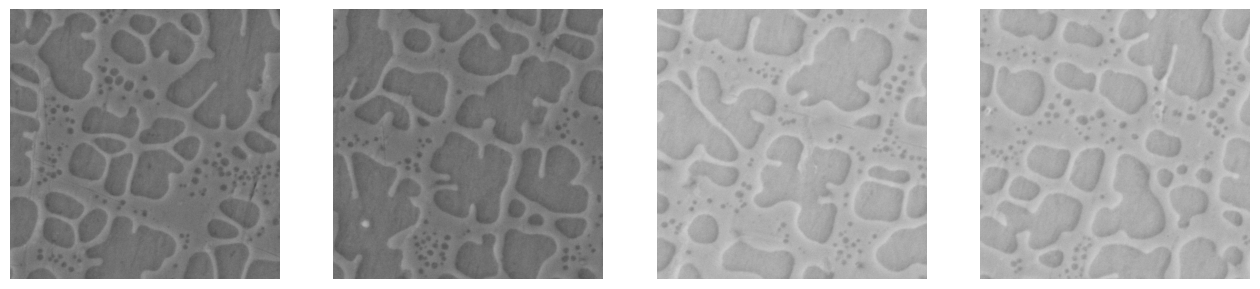

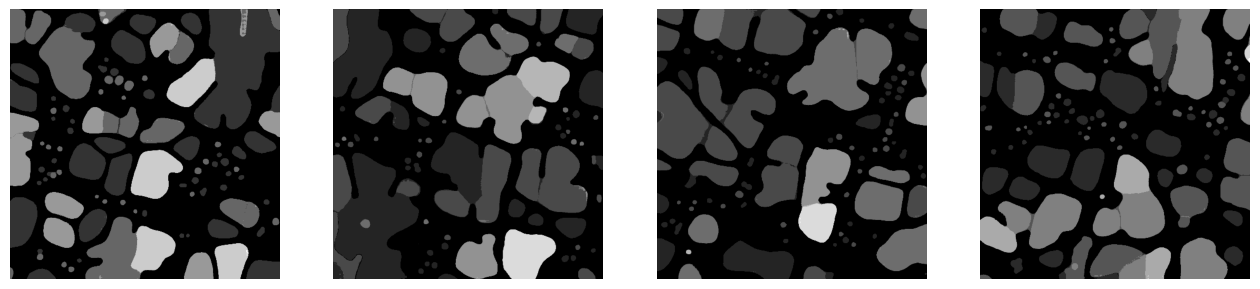

In [8]:
"""
    Inference
"""

from utils.prompt_generator import PromptGenerator

iou_list = []
image_list = []
result_list = []

for index, item in enumerate(dataset_image):
    image = cv2.imread(dataset_path + "image/" + dataset_image[index])
    image_list.append(image)

    label_image = cv2.imread(dataset_path + "label/" + dataset_label[index], 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # generate prompt points
    prompter = PromptGenerator(image, layers, scales, n_per_side_base, method_type)
    points_layers = prompter.generate_prompt_points()

    matsam_mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=None,
        point_grids=points_layers,
        pred_iou_thresh=pred_iou_thresh,
        crop_n_layers=layers,
        crop_n_points_downscale_factor=scales,
        box_nms_thresh=box_nms_thresh,
        crop_nms_thresh=crop_nms_thresh,
        stability_score_thresh=stability_score_thresh,
        points_per_batch=256,
        min_mask_region_area=0,  # Requires open-cv to run post-processing
    )

    masks = matsam_mask_generator.generate(image)
    print('Image[{0}] inference successfully, generated {1} masks.'.format(str(index + 1), str(len(masks))))

    result = np.zeros((masks[0]['segmentation'].shape[0], masks[0]['segmentation'].shape[1]))
    for i in range(0, len(masks)):
        tmp = np.uint8(masks[i]['segmentation'].astype(int) > 0) * 255
        image_avg_pixel = np.average(image[np.where(tmp > 0)])
        image_sum_area = np.sum(tmp == 255)

        # Set pixel and grayscale threshold based on regional characteristics
        grayscale_threshold = 255
        area_threshold = 50000

        if image_sum_area <= area_threshold and image_avg_pixel <= grayscale_threshold:
            """ This step is not required for polyphase structured data """

            result += tmp

    # When calculating IoU, pay attention to processing images with 0,1 values.
    # Do not enter 0,255 images, as overflow problems will occur.
    iou_score = round(Metric.get_iou(np.uint8(result > 0), np.uint8(label_image > 0)), 6)

    iou_list.append(iou_score)

    result_list.append(result)

print("Avg iou: {0}".format(str(round(sum(iou_list) / len(iou_list), 6))))

""" Visualization """
fig, axes = plt.subplots(1, len(image_list), figsize=(len(image_list) * 4, 6))
for index, item in enumerate(image_list):
    axes[index].imshow(item, cmap="gray")
    axes[index].axis('off')
plt.show()

fig, axes = plt.subplots(1, len(result_list), figsize=(len(result_list) * 4, 6))
for index, item in enumerate(result_list):
    axes[index].imshow(item, cmap="gray")
    axes[index].axis('off')
plt.show()

In [9]:
"""
    Dataset NBS-3
"""

dataset_path = '../dataset/nbs3/'

dataset_image = natsorted(os.listdir(dataset_path + 'image/'), alg=ns.PATH)
dataset_label = natsorted(os.listdir(dataset_path + 'label/'), alg=ns.PATH)

""" Define params """
layers = 0
scales = 3
n_per_side_base = 54
method_type = 2
pred_iou_thresh = 0.90
stability_score_thresh = 0.92
box_nms_thresh = 0.72
crop_nms_thresh = 0.72

Image[1] inference successfully, generated 130 masks.
Image[2] inference successfully, generated 127 masks.
Image[3] inference successfully, generated 97 masks.
Image[4] inference successfully, generated 81 masks.
Image[5] inference successfully, generated 49 masks.
Avg iou: 0.816729


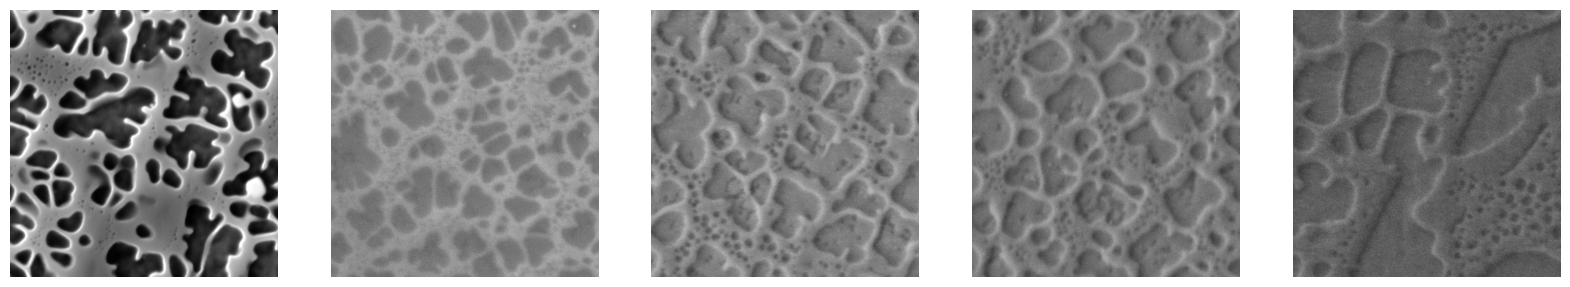

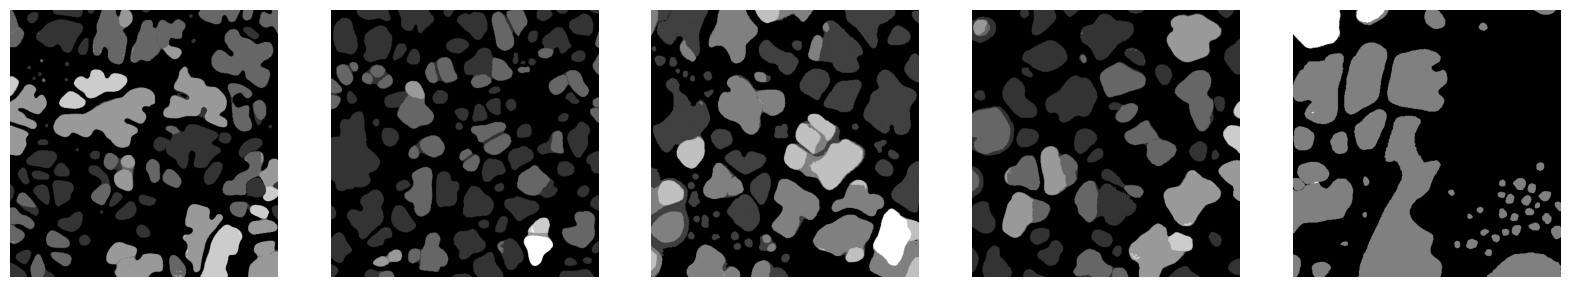

In [10]:
"""
    Inference
"""

from utils.prompt_generator import PromptGenerator

iou_list = []
image_list = []
result_list = []

for index, item in enumerate(dataset_image):
    image = cv2.imread(dataset_path + "image/" + dataset_image[index])
    image_list.append(image)

    label_image = cv2.imread(dataset_path + "label/" + dataset_label[index], 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # generate prompt points
    prompter = PromptGenerator(image, layers, scales, n_per_side_base, method_type)
    points_layers = prompter.generate_prompt_points()

    matsam_mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=None,
        point_grids=points_layers,
        pred_iou_thresh=pred_iou_thresh,
        crop_n_layers=layers,
        crop_n_points_downscale_factor=scales,
        box_nms_thresh=box_nms_thresh,
        crop_nms_thresh=crop_nms_thresh,
        stability_score_thresh=stability_score_thresh,
        points_per_batch=256,
        min_mask_region_area=0,  # Requires open-cv to run post-processing
    )

    masks = matsam_mask_generator.generate(image)
    print('Image[{0}] inference successfully, generated {1} masks.'.format(str(index + 1), str(len(masks))))

    result = np.zeros((masks[0]['segmentation'].shape[0], masks[0]['segmentation'].shape[1]))
    for i in range(0, len(masks)):
        tmp = np.uint8(masks[i]['segmentation'].astype(int) > 0) * 255
        image_avg_pixel = np.average(image[np.where(tmp > 0)])
        image_sum_area = np.sum(tmp == 255)

        # Set pixel and grayscale threshold based on regional characteristics
        grayscale_threshold = 255
        area_threshold = 50000

        if image_sum_area <= area_threshold and image_avg_pixel <= grayscale_threshold:
            """ This step is not required for polyphase structured data """

            result += tmp

    # When calculating IoU, pay attention to processing images with 0,1 values.
    # Do not enter 0,255 images, as overflow problems will occur.
    iou_score = round(Metric.get_iou(np.uint8(result > 0), np.uint8(label_image > 0)), 6)

    iou_list.append(iou_score)

    result_list.append(result)

print("Avg iou: {0}".format(str(round(sum(iou_list) / len(iou_list), 6))))

# """ Visualization """
fig, axes = plt.subplots(1, len(image_list), figsize=(len(image_list) * 4, 6))
for index, item in enumerate(image_list):
    axes[index].imshow(item, cmap="gray")
    axes[index].axis('off')
plt.show()

fig, axes = plt.subplots(1, len(result_list), figsize=(len(result_list) * 4, 6))
for index, item in enumerate(result_list):
    axes[index].imshow(item, cmap="gray")
    axes[index].axis('off')
plt.show()

In [11]:
"""
    Dataset AZA
"""

dataset_path = '../dataset/aza/'

dataset_image = natsorted(os.listdir(dataset_path + 'image/'), alg=ns.PATH)
dataset_label = natsorted(os.listdir(dataset_path + 'label/'), alg=ns.PATH)

""" Define params """
layers = 0
scales = 3
n_per_side_base = 32
method_type = 2
pred_iou_thresh = 0.85
stability_score_thresh = 0.88
box_nms_thresh = 0.7
crop_nms_thresh = 0.7

Image[1] inference successfully, generated 37 masks.
Image[2] inference successfully, generated 47 masks.
Avg iou: 0.961954


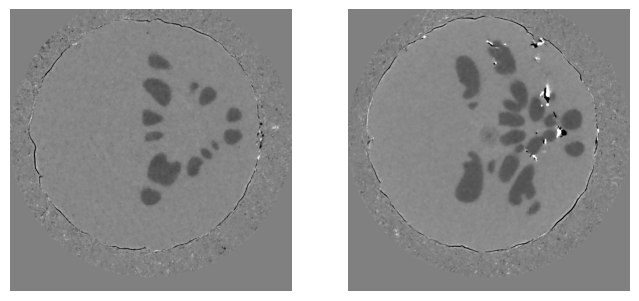

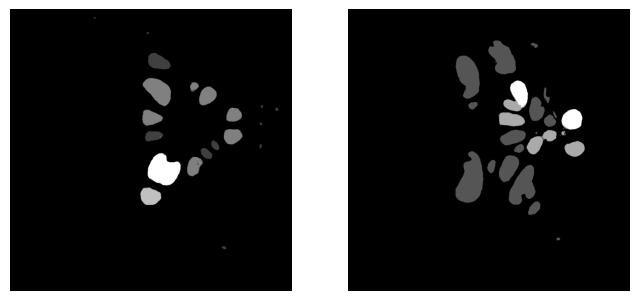

In [12]:
"""
    Inference
"""

from utils.prompt_generator import PromptGenerator

iou_list = []
image_list = []
result_list = []

for index, item in enumerate(dataset_image):
    image = cv2.imread(dataset_path + "image/" + dataset_image[index])
    image_list.append(image)

    label_image = cv2.imread(dataset_path + "label/" + dataset_label[index], 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # generate prompt points
    prompter = PromptGenerator(image, layers, scales, n_per_side_base, method_type)
    points_layers = prompter.generate_prompt_points()

    matsam_mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=None,
        point_grids=points_layers,
        pred_iou_thresh=pred_iou_thresh,
        crop_n_layers=layers,
        crop_n_points_downscale_factor=scales,
        box_nms_thresh=box_nms_thresh,
        crop_nms_thresh=crop_nms_thresh,
        stability_score_thresh=stability_score_thresh,
        points_per_batch=256,
        min_mask_region_area=0,  # Requires open-cv to run post-processing
    )

    masks = matsam_mask_generator.generate(image)
    print('Image[{0}] inference successfully, generated {1} masks.'.format(str(index + 1), str(len(masks))))

    result = np.zeros((masks[0]['segmentation'].shape[0], masks[0]['segmentation'].shape[1]))
    for i in range(0, len(masks)):
        tmp = np.uint8(masks[i]['segmentation'].astype(int) > 0) * 255
        image_avg_pixel = np.average(image[np.where(tmp > 0)])
        image_sum_area = np.sum(tmp == 255)

        # Set pixel and grayscale threshold based on regional characteristics
        grayscale_threshold = 105
        area_threshold = 15000

        if image_sum_area <= area_threshold and image_avg_pixel <= grayscale_threshold:
            """ This step is not required for polyphase structured data """

            result += tmp

    # When calculating IoU, pay attention to processing images with 0,1 values.
    # Do not enter 0,255 images, as overflow problems will occur.
    iou_score = round(Metric.get_iou(np.uint8(result > 0), np.uint8(label_image > 0)), 6)

    iou_list.append(iou_score)

    result_list.append(result)

print("Avg iou: {0}".format(str(round(sum(iou_list) / len(iou_list), 6))))

# """ Visualization """
fig, axes = plt.subplots(1, len(image_list), figsize=(len(image_list) * 4, 6))
for index, item in enumerate(image_list):
    axes[index].imshow(item, cmap="gray")
    axes[index].axis('off')
plt.show()

fig, axes = plt.subplots(1, len(result_list), figsize=(len(result_list) * 4, 6))
for index, item in enumerate(result_list):
    axes[index].imshow(item, cmap="gray")
    axes[index].axis('off')
plt.show()

In [14]:
"""
    Dataset UHCS
"""

dataset_path = '../dataset/uhcs/'

dataset_image = natsorted(os.listdir(dataset_path + 'image/'), alg=ns.PATH)
dataset_label = natsorted(os.listdir(dataset_path + 'label/'), alg=ns.PATH)

""" Define params """
layers = 0
scales = 3
n_per_side_base = 80
method_type = 2
pred_iou_thresh = 0.88
stability_score_thresh = 0.90
box_nms_thresh = 0.7
crop_nms_thresh = 0.7

Image[1] inference successfully, generated 1216 masks.
Image[2] inference successfully, generated 1149 masks.
Image[3] inference successfully, generated 1209 masks.
Image[4] inference successfully, generated 1094 masks.
Image[5] inference successfully, generated 1184 masks.
Avg iou: 0.760348


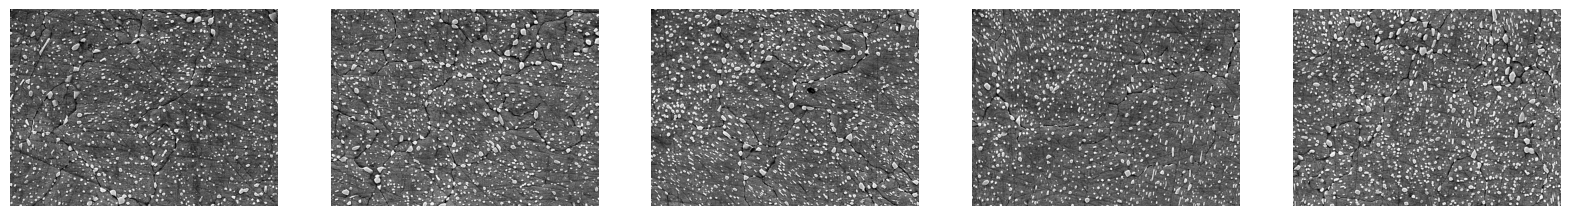

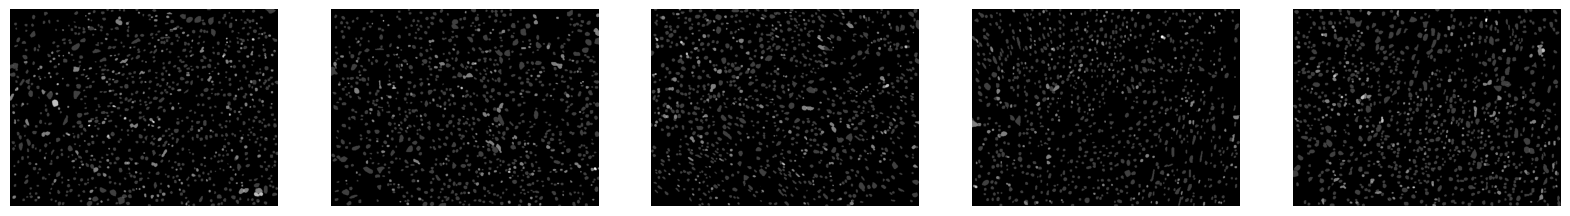

In [15]:
"""
    Inference
"""

from utils.prompt_generator import PromptGenerator

iou_list = []
image_list = []
result_list = []

for index, item in enumerate(dataset_image):
    image = cv2.imread(dataset_path + "image/" + dataset_image[index])
    image_list.append(image)

    label_image = cv2.imread(dataset_path + "label/" + dataset_label[index], 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # generate prompt points
    prompter = PromptGenerator(image, layers, scales, n_per_side_base, method_type)
    points_layers = prompter.generate_prompt_points()

    matsam_mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=None,
        point_grids=points_layers,
        pred_iou_thresh=pred_iou_thresh,
        crop_n_layers=layers,
        crop_n_points_downscale_factor=scales,
        box_nms_thresh=box_nms_thresh,
        crop_nms_thresh=crop_nms_thresh,
        stability_score_thresh=stability_score_thresh,
        points_per_batch=256,
        min_mask_region_area=0,  # Requires open-cv to run post-processing
    )

    masks = matsam_mask_generator.generate(image)
    print('Image[{0}] inference successfully, generated {1} masks.'.format(str(index + 1), str(len(masks))))

    result = np.zeros((masks[0]['segmentation'].shape[0], masks[0]['segmentation'].shape[1]))
    for i in range(0, len(masks)):
        tmp = np.uint8(masks[i]['segmentation'].astype(int) > 0) * 255
        image_avg_pixel = np.average(image[np.where(tmp > 0)])
        image_sum_area = np.sum(tmp == 255)

        # Set pixel and grayscale threshold based on regional characteristics
        grayscale_threshold = 255
        min_area_threshold = 2
        max_area_threshold = 250

        if min_area_threshold <= image_sum_area <= max_area_threshold and image_avg_pixel <= grayscale_threshold:
            """ This step is not required for polyphase structured data """

            result += tmp

    # When calculating IoU, pay attention to processing images with 0,1 values.
    # Do not enter 0,255 images, as overflow problems will occur.
    iou_score = round(Metric.get_iou(np.uint8(result > 0), np.uint8(label_image > 0)), 6)

    iou_list.append(iou_score)

    result_list.append(result)

print("Avg iou: {0}".format(str(round(sum(iou_list) / len(iou_list), 6))))

# """ Visualization """
fig, axes = plt.subplots(1, len(image_list), figsize=(len(image_list) * 4, 6))
for index, item in enumerate(image_list):
    axes[index].imshow(item, cmap="gray")
    axes[index].axis('off')
plt.show()

fig, axes = plt.subplots(1, len(result_list), figsize=(len(result_list) * 4, 6))
for index, item in enumerate(result_list):
    axes[index].imshow(item, cmap="gray")
    axes[index].axis('off')
plt.show()